# Model has been overfitting, so going to try some augmentation and regularisation

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torchvision.models.video as video_models
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import json

from train import train_model_4
import video_dataset as Dataset
from test import test_model


/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-07-18 17:54:46.729547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 17:54:46.930149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-18 17:54:47.014852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for p

In [3]:
model_3 = video_models.r3d_18(pretrained=True)
num_classes = 100
train_inst_path = './preprocessed/labels/asl100/train_instances_fixed_bboxes_short.json'
val_inst_path = './preprocessed/labels/asl100/val_instances_fixed_bboxes_short.json'
raw_path = '../data/WLASL2000'
classes_path = './wlasl_class_list.json'
transform3 = transforms.Compose([
  transforms.Lambda(lambda x: Dataset.correct_num_frames(x, 16, randomise=True)),  # (T, C, H, W)
  transforms.Lambda(lambda x: x.float() / 255.0),  # Convert
  transforms.Lambda(lambda x: Dataset.colour_jitter(x, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)),  # Apply colour jitter
  transforms.Lambda(lambda x: F.interpolate(x, size=(112, 112), mode='bilinear', align_corners=False)),  # Resize after normalization
  transforms.Lambda(lambda x: Dataset.normalise(x, mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])),  # Normalize per channel
  transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)),  # (T, C, H, W) -> (C, T, H, W)
]) #This time using:
#  random frame sampling and colour jitter

train_set_3 = Dataset.VideoDataset(
  root=raw_path,
  instances_path=train_inst_path,
  classes_path=classes_path,
  transform=transform3
)
val_set_3 = Dataset.VideoDataset(
  root=raw_path,
  instances_path=val_inst_path,
  classes_path=classes_path,
  transform=transform3
)
print(f"Number of training samples: {len(train_set_3)}")
print(f"Number of validation samples: {len(val_set_3)}")


/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of training samples: 1442
Number of validation samples: 338


In [4]:
train_loader_3 = DataLoader(
  train_set_3,
  batch_size=32, #I increased the temporal dimension, so batch size is lower
  shuffle=True,
  num_workers=2, # but can be set to 4
  drop_last=True,
)
val_loader_3 = DataLoader(
  val_set_3,
  batch_size=32, #apparently can be mroe than train batch size
  num_workers=2, 
  shuffle=False,
  drop_last=False
)
print(f"Train loader:\n{train_loader_3}")
print(f"Validation loader:\n{val_loader_3}")

Train loader:
Validation loader:


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
model_3.fc = nn.Sequential(
  nn.Dropout(p=0.5), #add dropout for regularization
  nn.Linear(model_3.fc.in_features, num_classes)  
)
model_3 = model_3.to(device)

for param in model_3.parameters():
  param.requires_grad = True
  
for layer_name in ['layer4', 'fc']:
  if hasattr(model_3, layer_name):
    for param in getattr(model_3, layer_name).parameters():
      param.requires_grad = True
      
for name, param in model_3.named_parameters():
  if param.requires_grad:
    print(f"Training parameter: {name}")
  else:
    print(f"Freezing parameter: {name}")
    
for name, module in model_3.named_modules():
  if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
    # Check if this BatchNorm is in a frozen layer
    is_in_frozen_layer = not any(unfreeze_layer in name for unfreeze_layer in ['layer4', 'fc'])
    
    if is_in_frozen_layer:
      module.eval()
      module.track_running_stats = False
      print(f"Set {name} to eval mode (frozen layer)")

Training parameter: stem.0.weight
Training parameter: stem.1.weight
Training parameter: stem.1.bias
Training parameter: layer1.0.conv1.0.weight
Training parameter: layer1.0.conv1.1.weight
Training parameter: layer1.0.conv1.1.bias
Training parameter: layer1.0.conv2.0.weight
Training parameter: layer1.0.conv2.1.weight
Training parameter: layer1.0.conv2.1.bias
Training parameter: layer1.1.conv1.0.weight
Training parameter: layer1.1.conv1.1.weight
Training parameter: layer1.1.conv1.1.bias
Training parameter: layer1.1.conv2.0.weight
Training parameter: layer1.1.conv2.1.weight
Training parameter: layer1.1.conv2.1.bias
Training parameter: layer2.0.conv1.0.weight
Training parameter: layer2.0.conv1.1.weight
Training parameter: layer2.0.conv1.1.bias
Training parameter: layer2.0.conv2.0.weight
Training parameter: layer2.0.conv2.1.weight
Training parameter: layer2.0.conv2.1.bias
Training parameter: layer2.0.downsample.0.weight
Training parameter: layer2.0.downsample.1.weight
Training parameter: la

In [7]:
trainable_params_3 = [p for p in model_3.parameters() if p.requires_grad]
optimizer_3 = torch.optim.Adam(
  trainable_params_3,
  lr=1e-3,
  weight_decay=1e-4)
schedular_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer_3,
  mode='min',
  factor=0.5,
  patience=5,
  verbose=True
)
  
# Adjust learning rate as needed
loss_func = nn.CrossEntropyLoss()
# train_losses_3, val_losses_3 = train_model_4(
#   model=model_3,
#   train_loader=train_loader_3,
#   optimizer=optimizer_3,
#   loss_func=loss_func,
#   epochs=30,
#   val_loader=val_loader_3,
#   schedular=schedular_3,
#   output='runs/r3d18_exp3'
# )

#this completed but I accidentally ran the cell again

/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### The model can probably go a bit further

In [ ]:
train_losses_3, val_losses_3 = train_model_4(
  model=model_3,
  train_loader=train_loader_3,
  optimizer=optimizer_3,
  loss_func=loss_func,
  epochs=100,
  val_loader=val_loader_3,
  schedular=schedular_3,
  output='runs/r3d18_exp3',
  load='runs/r3d18_exp3/checkpoints/checkpoint_74.pth'  # Load the model from the checkpoint
)

### Expriment 2 is still the winner, and by far the fastest. This experiment performed worse and took longer

/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Plot saved to: runs/r3d18_exp3/logs/r3d18_exp3_losses.png


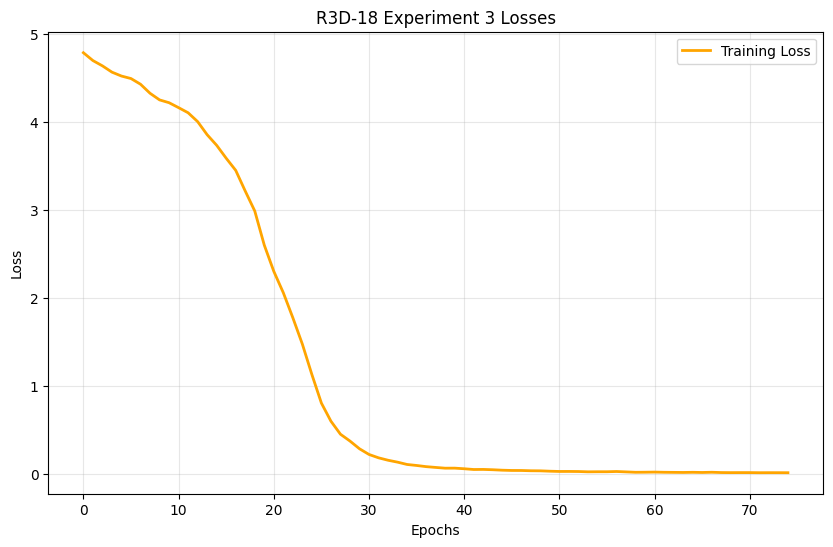

Saved plot to runs/r3d18_exp3/logs/r3d18_exp3_losses.png


<Figure size 640x480 with 0 Axes>

In [1]:
from utils import plot_from_simple_list, load_tensorboard_json
import json

train_losses_3 = load_tensorboard_json('runs/r3d18_exp3/logs/r3d18_exp3_train_loss.json')
val_losses_3 = load_tensorboard_json('runs/r3d18_exp3/logs/r3d18_exp3_val_loss.json')

plot_from_simple_list(
    train_losses_3,
    val_losses_3,
    title='R3D-18 Experiment 3 Losses',
    save_path='runs/r3d18_exp3/logs/r3d18_exp3_losses.png'
)
    

Plot saved to: runs/r3d18_exp3/logs/r3d18_exp3_val_loss_logscale.png


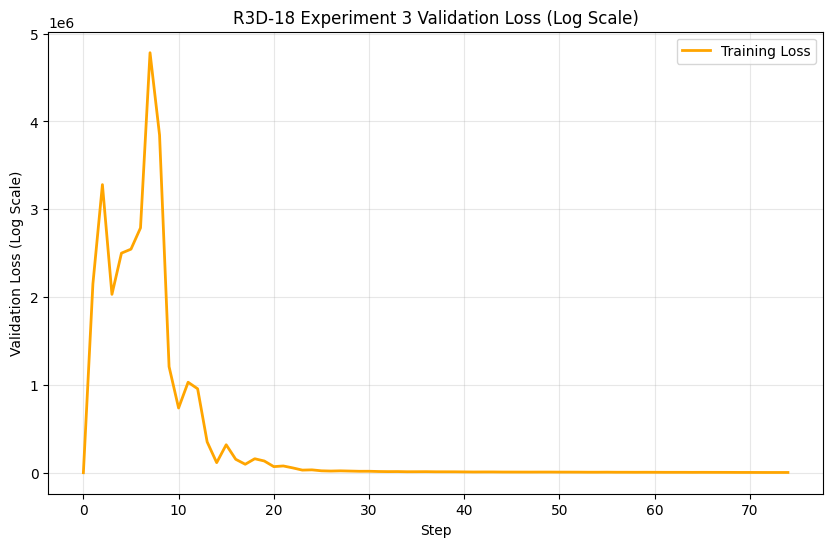

Saved plot to runs/r3d18_exp3/logs/r3d18_exp3_val_loss_logscale.png


<Figure size 640x480 with 0 Axes>

In [2]:
val_losses_3_logscale = load_tensorboard_json('runs/r3d18_exp3/logs/r3d18_exp3_val_loss_logscale.json')
plot_from_simple_list(
  val_losses_3_logscale,
  title='R3D-18 Experiment 3 Validation Loss (Log Scale)',
  xlabel='Step',
  ylabel='Validation Loss (Log Scale)',
  save_path='runs/r3d18_exp3/logs/r3d18_exp3_val_loss_logscale.png'
)

### This data is better seen in tensorboard, but the validation accuracy on this experiment was ridiculous. not sure what caused it